## Import Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

/home/minh-nam/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using PyTorch version 1.10.2


## Preparing Training and Test Sets

In [2]:
VAL_SIZE = 0.2

class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal/images', 'Viral Pneumonia/images', 'COVID/images']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'train'))
    os.mkdir(os.path.join(root_dir, 'test'))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'train', c))
        os.mkdir(os.path.join(root_dir, 'test', c))

    for i, d, in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, 'train', class_names[i]))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, 'train', c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, int(len(images) * VAL_SIZE))
        for image in selected_images:
            source_path = os.path.join(root_dir, 'train', c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)





## Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name, verbose=1):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            if verbose == 1:
                print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)


## Image transformation

In [4]:
train_transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

In [5]:
test_transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

## Data Loader

In [6]:
train_dirs = {}
for class_name in class_names:
    train_dirs[class_name] = os.path.join(root_dir, 'train', class_name)


train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 8154 normal examples
Found 1076 viral examples
Found 2893 covid examples


In [7]:
test_dirs = {}
for class_name in class_names:
    test_dirs[class_name] = os.path.join(root_dir, 'test', class_name)

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 2038 normal examples
Found 269 viral examples
Found 723 covid examples


In [8]:
batch_size = 6

dataloader_train = torch.utils.data.DataLoader(train_dataset, 
                                        batch_size=batch_size,
                                        shuffle=True)

dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)

print('Num. of training batches', len(dataloader_train))
print('Num. of test batches', len(dataloader_test))

Num. of training batches 2021
Num. of test batches 505


## Data Visualization

In [9]:
cllass_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        col = 'green' if preds[i] == labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

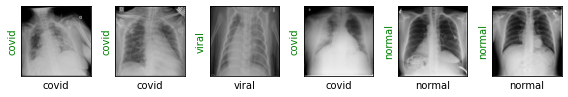

In [10]:
images, labels = next(iter(dataloader_train))
show_images(images, labels, labels)

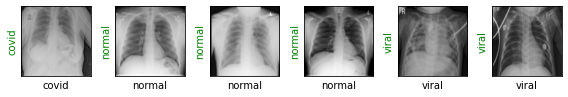

In [11]:
images, labels = next(iter(dataloader_test))
show_images(images, labels, labels)

## Create the Model

In [13]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# from torchsummary import summary

# first_parameter = next(resnet18.parameters())
# input_shape = first_parameter.size()
# print(input_shape)

# summary(resnet18, input_shape)

In [16]:
resnet18.fc = torch.nn.Linear(in_features=512,
                              out_features=3)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet18.parameters(),
                             lr=1e-4)

In [17]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dataloader_test))
    outputs = resnet18(images)
    _, preds = torch.max(input=outputs, dim=1) # return probalility of the max class and indices of the class
    # preds = torch.argmax(input=Tensor)
    show_images(images, labels, preds)

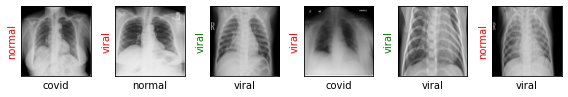

In [18]:
show_preds()

## Training the Model

In [19]:
def train(epochs):
    print("Starting training..")
    for e in range(0, epochs):
        print('=' * 20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('=' * 20)
        
        train_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dataloader_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 ==0:
                print("Evaluating at step", train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dataloader_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(input=outputs, dim=1)
                    acc += sum(preds==labels).numpy()
                    
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95:
                    print("Performance condition satisfied..")
                    return
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
        
                        
        

Starting training..
Starting epoch 1/1
Evaluating at step 0
Val loss: 1.1163, Acc: 0.3370


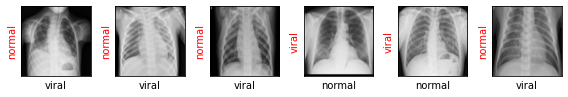

Evaluating at step 20
Val loss: 0.7082, Acc: 0.7059


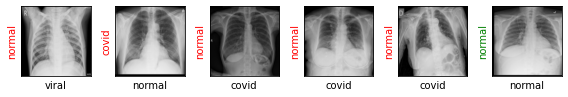

Evaluating at step 40
Val loss: 0.4232, Acc: 0.8343


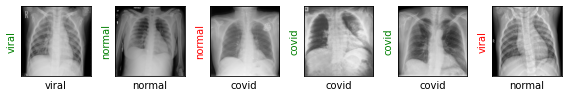

Evaluating at step 60
Val loss: 0.3822, Acc: 0.8492


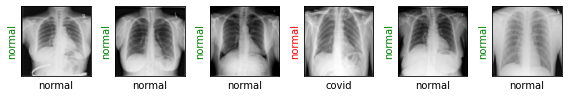

Evaluating at step 80
Val loss: 0.3072, Acc: 0.8723


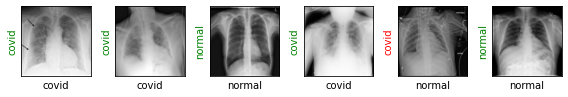

Evaluating at step 100
Val loss: 0.2597, Acc: 0.9046


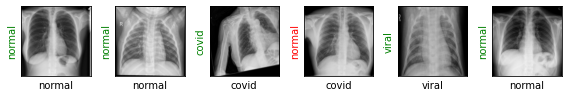

Evaluating at step 120
Val loss: 0.2690, Acc: 0.8884


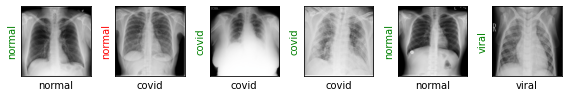

Evaluating at step 140
Val loss: 0.2995, Acc: 0.8851


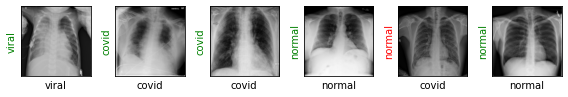

Evaluating at step 160
Val loss: 0.2152, Acc: 0.9165


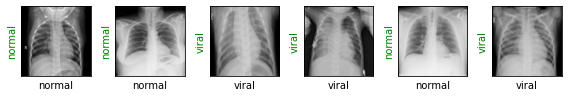

Evaluating at step 180
Val loss: 0.2253, Acc: 0.9076


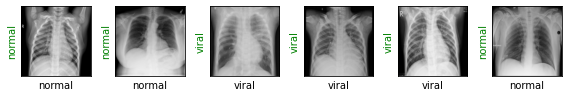

Evaluating at step 200
Val loss: 0.2522, Acc: 0.9007


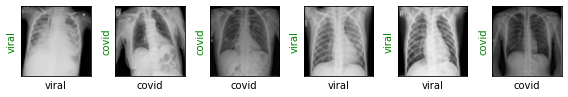

Evaluating at step 220
Val loss: 0.1771, Acc: 0.9267


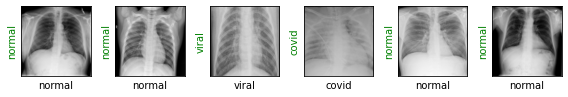

Evaluating at step 240
Val loss: 0.2533, Acc: 0.9026


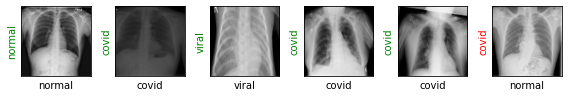

Evaluating at step 260
Val loss: 0.1726, Acc: 0.9380


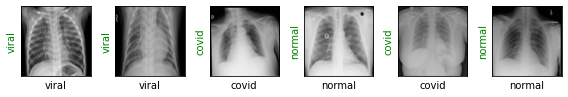

Evaluating at step 280
Val loss: 0.2206, Acc: 0.9201


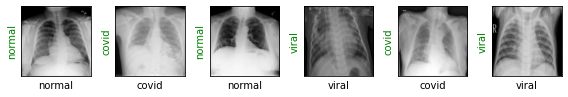

Evaluating at step 300
Val loss: 0.3344, Acc: 0.8848


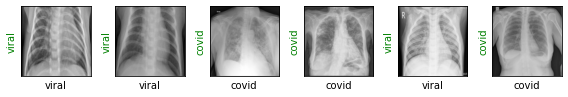

Evaluating at step 320
Val loss: 0.3157, Acc: 0.9053


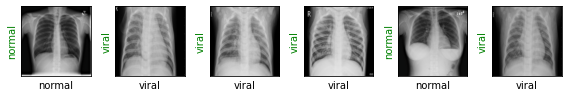

Evaluating at step 340
Val loss: 0.2751, Acc: 0.8911


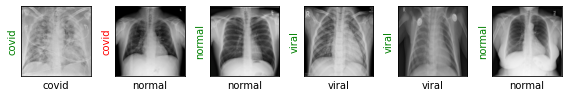

Evaluating at step 360
Val loss: 0.1603, Acc: 0.9455


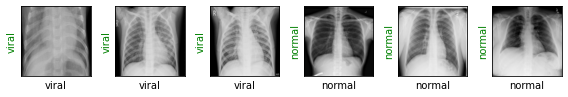

Evaluating at step 380
Val loss: 0.1626, Acc: 0.9442


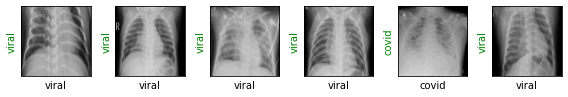

Evaluating at step 400
Val loss: 0.1863, Acc: 0.9317


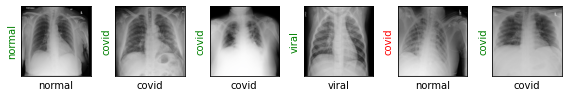

Evaluating at step 420
Val loss: 0.1816, Acc: 0.9455


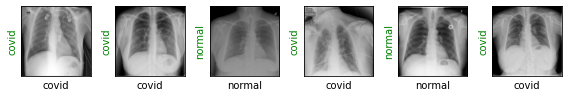

Evaluating at step 440
Val loss: 0.1959, Acc: 0.9347


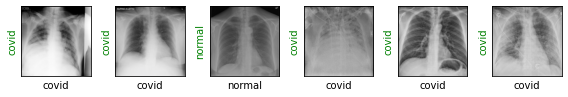

Evaluating at step 460
Val loss: 0.1273, Acc: 0.9541


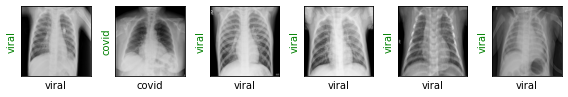

Performance condition satisfied..


In [20]:
train(epochs=1)

In [31]:
PATH = 'entire_model.pt'

torch.save(resnet18, PATH)


## Final Result

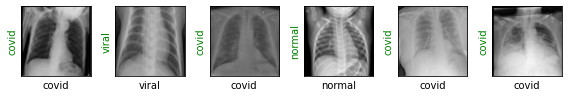

In [35]:
resnet18 = torch.load(PATH)
show_preds()

Text(0.5, 69.0, 'Predicted label')

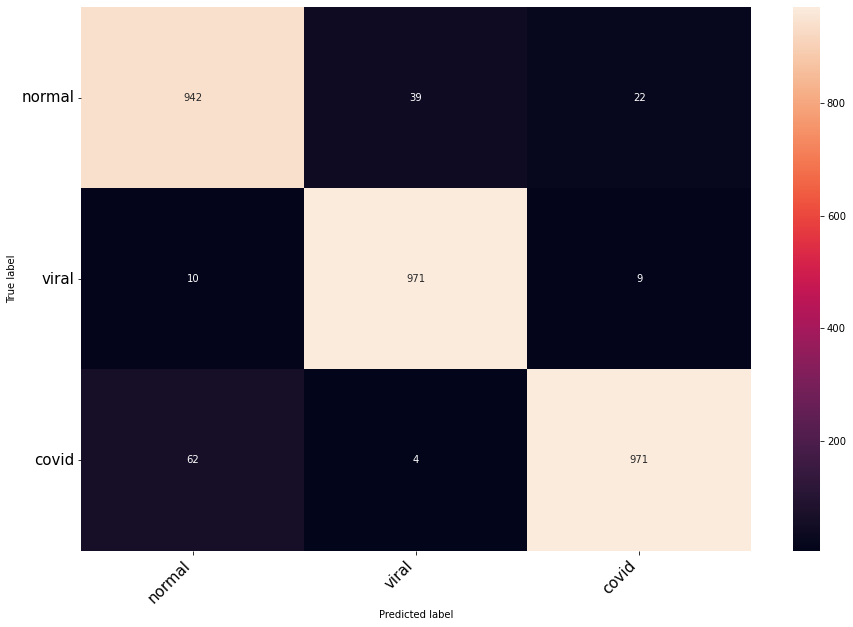

In [29]:
import pandas as pd
import seaborn as sns

DEVICE = 'cpu'
nb_classes = 3

confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloader_test):
        inputs = inputs.to(DEVICE)
        classes = classes.to(DEVICE)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [27]:
from sklearn.metrics import confusion_matrix

nb_classes = 3
device = 'cpu'

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloader_test):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[ 949   26   24]
 [   8 1020    7]
 [  62    6  928]]
[94.99499499 98.55072464 93.17269076]
